# Srilanka Dengue Outbreak Forecasting using Darts

## Environment Setup

In [1]:
!pip install darts
!pip install dask[dataframe]
!pip install statsmodels

## 1. Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from darts import TimeSeries
from sklearn.linear_model import Ridge

%matplotlib inline

## 2. Load Dataset

In [3]:
df = pd.read_csv("../data/Copy of Sri_lanka_dengue_cases_weather_weekly_2007_2024_.csv")

In [4]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Month,Year,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Total Rain (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Weather Code,Avg Daylight Duration (hours),Avg Sunrise Time,Avg Sunset Time
0,Ampara,0,2007-01-01,1,2007,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,8.0,18.2000,44.3,3,11.714583,376,1079
1,Ampara,0,2007-01-08,1,2007,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,86.1,17.0250,43.6,53,11.733333,378,1082
2,Ampara,0,2007-01-15,1,2007,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,3.1,20.1875,48.2,51,11.754167,380,1085
3,Ampara,0,2007-01-22,1,2007,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,53.6,17.2000,42.5,61,11.783333,381,1088
4,Ampara,0,2007-01-29,1,2007,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,8.2,17.2625,40.0,51,11.812500,382,1090


In [5]:
len(df)

22900

In [6]:
districts = df['District'].unique()
districts

array(['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo',
       'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara', 'Kandy',
       'Kegalle', 'Kilinochchi', 'Kurunegala', 'Mannar', 'Matale',
       'Matara', 'Monaragala', 'Mullaitivu', 'NuwaraEliya', 'Polonnaruwa',
       'Puttalam', 'Ratnapura', 'Trincomalee', 'Vavuniya'], dtype=object)

## 3. Small Visualization

In [7]:
# Check Duplicate values
duplicates = df[['District', 'Week_Start_Date', 'Week_End_Date']].duplicated().any()
if duplicates:
    print("There are duplicate values.")
else:
    print("No duplicates found.")

No duplicates found.


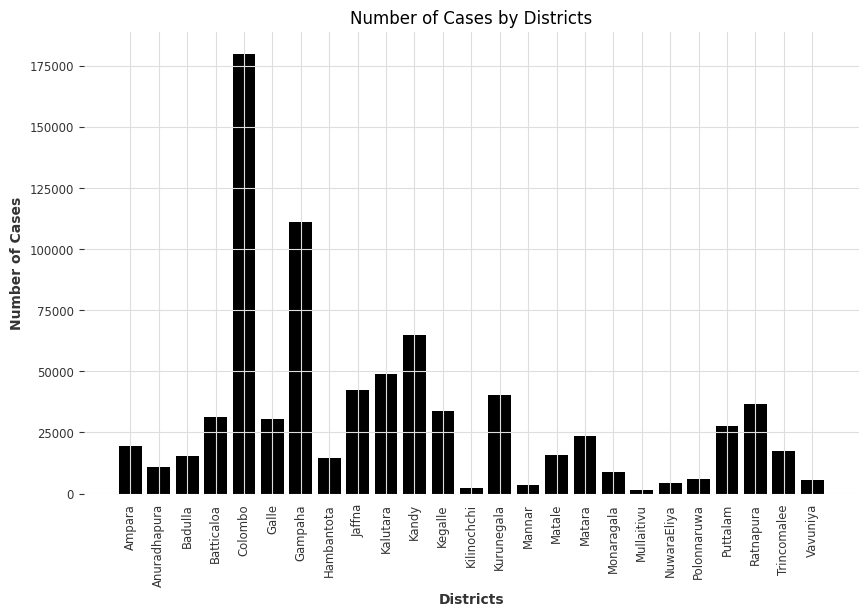

In [8]:
# Group by District and sum the Number of Cases
district_cases = df.groupby('District')['Number_of_Cases'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(district_cases['District'], district_cases['Number_of_Cases'])
plt.xlabel('Districts')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Districts')
plt.xticks(rotation=90)
plt.show()


## 4. Minor pre-processing
1. Only taking single timestamp for each row. Either `Week_Start_Date` or `Week_Start_Date`. We gonna take `Week_End_Date`.
2. Convert the `Week_End_Date` to Python Datetime format.
3. Eliminate un-used features such as `Week_Start_Date`, `Month`, `Year`, and `Week`

In [9]:
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])

In [10]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Month,Year,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Total Rain (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Weather Code,Avg Daylight Duration (hours),Avg Sunrise Time,Avg Sunset Time
0,Ampara,0,2007-01-01,1,2007,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,8.0,18.2000,44.3,3,11.714583,376,1079
1,Ampara,0,2007-01-08,1,2007,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,86.1,17.0250,43.6,53,11.733333,378,1082
2,Ampara,0,2007-01-15,1,2007,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,3.1,20.1875,48.2,51,11.754167,380,1085
3,Ampara,0,2007-01-22,1,2007,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,53.6,17.2000,42.5,61,11.783333,381,1088
4,Ampara,0,2007-01-29,1,2007,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,8.2,17.2625,40.0,51,11.812500,382,1090


** The trend of cases of all 25 districts

In [11]:
from darts.models import NBEATSModel, TransformerModel, TFTModel, RandomForest, CatBoostModel, RegressionModel, LightGBMModel, ARIMA

/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
pl_trainer_kwargs={"accelerator": "cpu"}

In [215]:
nbeats = NBEATSModel(                 # or 'GRU' or 'RNN'
    input_chunk_length=52,           # length of input sequence
    output_chunk_length=12,
    dropout=0.4,                     # dropout to avoid overfitting
    batch_size=32,                   # batch size during training
    n_epochs=100,                    # number of epochs for training
    activation='LeakyReLU',
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs,
    save_checkpoints=True
)

transformer = TransformerModel(
    input_chunk_length=52,           # length of input sequence
    output_chunk_length=12,
    norm_type="LayerNorm",
    dropout=0.4,                     # dropout to avoid overfitting
    batch_size=32,                   # batch size during training
    n_epochs=100,                    # number of epochs for training
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs,
    save_checkpoints=True
)
tft = TFTModel(
    input_chunk_length=52,           # length of input sequence
    output_chunk_length=12,
    dropout=0.4,                     # dropout to avoid overfitting
    batch_size=32,                   # batch size during training
    n_epochs=100,                    # number of epochs for training
    random_state=42,
    pl_trainer_kwargs=pl_trainer_kwargs,
    add_relative_index=True,
    save_checkpoints=True
)
rf = RandomForest(
    lags = [-1, -2, -3, -4, -5],
    lags_future_covariates=[0],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
cat = CatBoostModel(
    lags = [-1, -2, -3, -52],
    lags_future_covariates=[0],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
reg = RegressionModel(
    lags = [-1, -2, -3, -52],
    lags_future_covariates=[0],
    model = Ridge(),
    output_chunk_length=12,  # Number of time steps predicted at once (per chunk) by the internal model.
)
lgbm = LightGBMModel(
    lags = [-1, -2, -3, -52],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
ar = ARIMA(p=5, d=1, q=1)
reg = RegressionModel(
    lags = [-10],
    lags_future_covariates=[0],
    model = Ridge(),
    output_chunk_length=12,  # Number of time steps predicted at once (per chunk) by the internal model.
)

In [216]:
import pickle
from darts.metrics import rmse
def train(train_series, val_series, model, future_covariates):
    #model.fit(train_series, future_covariates=future_covariates)
    model.fit(train_series)
    #Forecast for the next 12 weeks
    #forecast = model.predict(n=len(val_series), future_covariates=future_covariates)
    forecast = model.predict(n=len(val_series))
    error_rmse = rmse(val_series, forecast)
    print(error_rmse)
    # Save the model using pickle
    with open("Kalutara_ARIMA.pkl", 'wb') as f:
        pickle.dump(model, f)

In [217]:
def main(data):
    # Filter data for the specified district
    district_data = data[data['District'] == "Kalutara"]

    # Ensure the 'Week_End_Date' column is in datetime format
    district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])

    # Prepare the data for ARIMA
    series = TimeSeries.from_dataframe(district_data, time_col='Week_End_Date', value_cols=['Number_of_Cases', 'Avg Max Temp (°C)', "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Sunrise Time", "Avg Sunset Time", "Avg Wind Speed (km/h)"])

    # Split series
    # Set aside the last 12 weeks as a validation series
    train_data, val_data = series["Number_of_Cases"][:-12], series["Number_of_Cases"][-12:]
    future_covariates = series[["Avg Max Temp (°C)", "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Sunrise Time", "Avg Sunset Time", "Avg Wind Speed (km/h)"]]

    print(f"Training length: {len(train_data)}")
    print(f"Validation length: {len(val_data)}")

    train(train_data, val_data, ar, future_covariates)

In [218]:
results = main(df)

/tmp/ipykernel_6478/2109517433.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 904
Validation length: 12


13.296170945792037


In [219]:
from typing import Tuple
from darts.models import ARIMA
from darts import TimeSeries
from darts.metrics import rmse


def train_arima(
    train_series: TimeSeries,
    val_series: TimeSeries,
    p: int,
    d: int,
    q: int
) -> Tuple[float, ARIMA]:
    """
    Train an ARIMA model with specified p, d, q values and compute RMSE on validation data.

    Args:
        train_series (TimeSeries): Training data for the target variable.
        val_series (TimeSeries): Validation data for the target variable.
        p (int): Autoregressive part (number of lags).
        d (int): Differencing part (number of differences needed for stationarity).
        q (int): Moving average part (number of lagged forecast errors).

    Returns:
        Tuple[float, ARIMA]: The RMSE value and the trained ARIMA model instance.
    """
    # Initialize the ARIMA model with specified p, d, q values
    model = ARIMA(p=p, d=d, q=q)
    
    # Fit the model on the training data
    model.fit(train_series)
    
    # Forecast the next n points, where n is the length of the validation set
    forecast = model.predict(n=len(val_series))
    
    # Calculate RMSE between the validation data and the forecast
    error_rmse = rmse(val_series, forecast)
    print(f"RMSE for ARIMA({p},{d},{q}): {error_rmse}")
    
    return error_rmse, model

In [220]:
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

arima_configurations = [(p, d, q) for p in p_values for d in d_values for q in q_values]


results = []
# Filter data for the specified district
district_data = df[df['District'] == "Ratnapura"]

# Ensure the 'Week_End_Date' column is in datetime format
district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])

# Prepare the data for ARIMA
series = TimeSeries.from_dataframe(district_data, time_col='Week_End_Date', value_cols=['Number_of_Cases', 'Avg Max Temp (°C)', "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Sunrise Time", "Avg Sunset Time", "Avg Wind Speed (km/h)"])

# Split series
# Set aside the last 12 weeks as a validation series
train_data, val_data = series["Number_of_Cases"][:-12], series["Number_of_Cases"][-12:]

print(f"Training length: {len(train_data)}")
print(f"Validation length: {len(val_data)}")
# Iterate through each lags configuration
for lags in arima_configurations:
    # Train the model and compute RMSE
    error_rmse, trained_model = train_arima(
        train_data,
        val_data,
        lags[0],
        lags[1],
        lags[2]
    )
    # Store the results
    results.append({
        'pdq': f"({lags[0]},{lags[1]},{lags[2]})",
        'RMSE': error_rmse
    })
    
print(results)
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Display all results sorted by RMSE
print("\nAll ARIMA Configurations and their RMSE:")
print(results_df.sort_values('RMSE').reset_index(drop=True))

# Identify the configuration with the minimum RMSE
if not results_df.empty:
    best_config = results_df.loc[results_df['RMSE'].idxmin()]
    print("\nBest ARIMA Configuration:")
    print(f"pdq: {best_config['pdq']} with RMSE: {best_config['RMSE']}")
else:
    print("No successful ARIMA configurations were found.")


/tmp/ipykernel_6478/2802493776.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 904
Validation length: 12
RMSE for ARIMA(0,0,0): 53.43796807141182
RMSE for ARIMA(0,0,1): 53.39612282345499
RMSE for ARIMA(0,0,2): 53.41356216667263
RMSE for ARIMA(0,0,3): 54.22150244063818
RMSE for ARIMA(0,1,0): 48.69377099109632
RMSE for ARIMA(0,1,1): 47.16952268495625
RMSE for ARIMA(0,1,2): 48.55159519175431
RMSE for ARIMA(0,1,3): 48.51634671438098
RMSE for ARIMA(0,2,0): 93.52495210726745


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE for ARIMA(0,2,1): 48.45848176703785
RMSE for ARIMA(0,2,2): 46.91253732617551
RMSE for ARIMA(0,2,3): 48.3420023014232
RMSE for ARIMA(1,0,0): 51.682641864043376
RMSE for ARIMA(1,0,1): 50.4108443465638
RMSE for ARIMA(1,0,2): 52.104744169620055
RMSE for ARIMA(1,0,3): 52.547755143928455
RMSE for ARIMA(1,1,0): 47.41476637935178
RMSE for ARIMA(1,1,1): 47.65553349138216
RMSE for ARIMA(1,1,2): 48.535466989110525
RMSE for ARIMA(1,1,3): 46.004531655271414
RMSE for ARIMA(1,2,0): 93.52495210726724
RMSE for ARIMA(1,2,1): 47.1651836509258
RMSE for ARIMA(1,2,2): 47.407080756769346
RMSE for ARIMA(1,2,3): 46.93129437826708
RMSE for ARIMA(2,0,0): 50.36036750116219
RMSE for ARIMA(2,0,1): 50.67421072713989
RMSE for ARIMA(2,0,2): 52.44323480818255
RMSE for ARIMA(2,0,3): 52.54969241707213
RMSE for ARIMA(2,1,0): 47.85747430528071


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RMSE for ARIMA(2,1,1): 47.94335060680765
RMSE for ARIMA(2,1,2): 49.482746126909355
RMSE for ARIMA(2,1,3): 44.82000034035303
RMSE for ARIMA(2,2,0): 68.20176514349014
RMSE for ARIMA(2,2,1): 47.61934083691913
RMSE for ARIMA(2,2,2): 47.266191647262396
RMSE for ARIMA(2,2,3): 47.569799836961565
RMSE for ARIMA(3,0,0): 51.319582673490515
RMSE for ARIMA(3,0,1): 51.997375621749995
RMSE for ARIMA(3,0,2): 52.482137746405854
RMSE for ARIMA(3,0,3): 52.52693681513938
RMSE for ARIMA(3,1,0): 48.10505622166946
RMSE for ARIMA(3,1,1): 48.34209614930924
RMSE for ARIMA(3,1,2): 49.55972305929352


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(3,1,3): 45.25769222130332
RMSE for ARIMA(3,2,0): 52.53246603869853
RMSE for ARIMA(3,2,1): 47.899331929839924


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(3,2,2): 48.20025038433937


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(3,2,3): 47.965322734647614
RMSE for ARIMA(4,0,0): 52.353601106848004
RMSE for ARIMA(4,0,1): 52.33454402604402
RMSE for ARIMA(4,0,2): 52.58223855546416
RMSE for ARIMA(4,0,3): 52.52856577001411
RMSE for ARIMA(4,1,0): 48.84418719266476
RMSE for ARIMA(4,1,1): 44.63497529556731
RMSE for ARIMA(4,1,2): 44.39086650992464


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(4,1,3): 45.43610677137294
RMSE for ARIMA(4,2,0): 45.81822061956495
RMSE for ARIMA(4,2,1): 48.61982450245873


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(4,2,2): 47.9838017950819


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(4,2,3): 48.108157520208344
RMSE for ARIMA(5,0,0): 52.331026798368924
RMSE for ARIMA(5,0,1): 52.34293822112859
RMSE for ARIMA(5,0,2): 52.38788053558018


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(5,0,3): 52.296412986973664
RMSE for ARIMA(5,1,0): 50.29395123454355
RMSE for ARIMA(5,1,1): 44.338798708702925


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(5,1,2): 44.728585182875136


/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for ARIMA(5,1,3): 44.271624566222336
RMSE for ARIMA(5,2,0): 47.75421523099842
RMSE for ARIMA(5,2,1): 50.04788126816717
RMSE for ARIMA(5,2,2): 48.59854329683194
RMSE for ARIMA(5,2,3): 48.64931439465691
[{'pdq': '(0,0,0)', 'RMSE': 53.43796807141182}, {'pdq': '(0,0,1)', 'RMSE': 53.39612282345499}, {'pdq': '(0,0,2)', 'RMSE': 53.41356216667263}, {'pdq': '(0,0,3)', 'RMSE': 54.22150244063818}, {'pdq': '(0,1,0)', 'RMSE': 48.69377099109632}, {'pdq': '(0,1,1)', 'RMSE': 47.16952268495625}, {'pdq': '(0,1,2)', 'RMSE': 48.55159519175431}, {'pdq': '(0,1,3)', 'RMSE': 48.51634671438098}, {'pdq': '(0,2,0)', 'RMSE': 93.52495210726745}, {'pdq': '(0,2,1)', 'RMSE': 48.45848176703785}, {'pdq': '(0,2,2)', 'RMSE': 46.91253732617551}, {'pdq': '(0,2,3)', 'RMSE': 48.3420023014232}, {'pdq': '(1,0,0)', 'RMSE': 51.682641864043376}, {'pdq': '(1,0,1)', 'RMSE': 50.4108443465638}, {'pdq': '(1,0,2)', 'RMSE': 52.104744169620055}, {'pdq': '(1,0,3)', 'RMSE': 52.547755143928455}, {'pdq': '(1,1,0)', 'RMSE': 47.4147663793

/home/surajkarki/Documents/My Workspace/Coding Works/omdena/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('data/Copy of Sri_lanka_dengue_cases_weather_weekly_2007_2024_.csv')

# Ensure the date is in datetime format
data['Week_End_Date'] = pd.to_datetime(data['Week_End_Date'])

# Sort the data by date
data = data.sort_values(by='Week_End_Date')

# Select features and target
features = ['Avg Max Temp (°C)', 'Total Precipitation (mm)']
target = 'Number_of_Cases'

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Initialize dictionary to store forecasts and RMSE
forecast_results = {}
rmse_comparison = []

# Store future forecast values for averaging
future_forecasts_all_districts = []

# Iterate through districts
for district in data['District'].unique():
    # Filter data for the current district
    district_data = data[data['District'] == district]

    # Ensure there are enough data points
    if len(district_data) < 532:
        print(f"Not enough data for {district}. Skipping.")
        continue

    # Prepare features and target variables
    district_data['lag_1'] = district_data[target].shift(1)
    district_data['rolling_mean_3'] = district_data[target].rolling(window=3).mean()
    district_data = district_data.dropna()

    X = district_data[['lag_1', 'rolling_mean_3'] + features]
    y = district_data[target]

    # Split training data (2007 up to May 7, 2024) and testing data (May 7 to 12 weeks after)
    train_data = district_data[district_data['Week_End_Date'] <= '2024-04-29']
    test_data = district_data[district_data['Week_End_Date'] > '2024-04-29']


    X_train = train_data[['lag_1', 'rolling_mean_3'] + features]
    y_train = train_data[target]
    X_test = test_data[['lag_1', 'rolling_mean_3'] + features]
    y_test = test_data[target]

    # Train and evaluate Gradient Boosting
    model_gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6)
    model_gb.fit(X_train, y_train)

    # Forecast for the test period (May 7 to 12 weeks)
    y_pred_gb = model_gb.predict(X_test)
    rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
    rmse_comparison.append((district, rmse_gb))

    # Keep actual data from May 7, 2024, to July 30, 2024
    forecast_actual_data = pd.DataFrame({
        'Week_End_Date': test_data['Week_End_Date'],
        'Actual_Dengue_Cases': test_data[target].values,
        'Predicted_Dengue_Cases': y_pred_gb
    })

    # Store forecast results
    forecast_results[district] = forecast_actual_data

    # Plot results for this district
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_actual_data['Week_End_Date'], forecast_actual_data['Actual_Dengue_Cases'], label='Actual (Test)')
    plt.plot(forecast_actual_data['Week_End_Date'], forecast_actual_data['Predicted_Dengue_Cases'],
             label='Predicted (GB)', linestyle='--', marker='^')
    plt.xlabel('Date')
    plt.ylabel('Dengue Cases')
    plt.title(f'Forecast for {district} (May 7, 2024 - July 30, 2024)')
    plt.legend()
    plt.show()

# Calculate mean RMSE across all districts
mean_rmse = np.mean([rmse for _, rmse in rmse_comparison])

# Print RMSE results for each district
print("\nGradientBoosting RMSE per district:")
for district, rmse in rmse_comparison:
    print(f"{district}: {rmse}")
print(f"\nMean RMSE across all districts: {mean_rmse}")